In [1]:
"""Data inspection."""

'Data inspection.'

In [30]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import sklearn

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

PATH = '/scratch/users/johmathe/output'
DEVICE='cuda'

Text(0.5, 1.0, 'Test Loss')

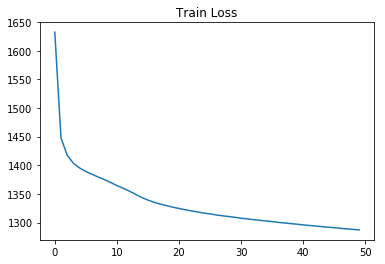

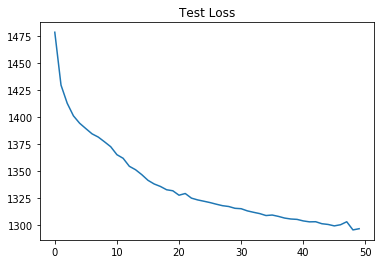

In [17]:
n_epoch = 49
train_losses = []
test_losses = []
for i in range(n_epoch+1):
    train_test = pickle.load(open(f'{PATH}/training/losses/epoch_{i}.pkl', 'rb'))
    train_losses.append(train_test['train_loss'])
    test_losses.append(train_test['test_loss'])

plt.plot(train_losses)
plt.title('Train Loss')
plt.figure()
plt.plot(test_losses)
plt.title('Test Loss')

In [8]:
n_epoch = 49
foo = np.load(f'{PATH}/training/imgs/epoch_{n_epoch}_data.npy')
recon = np.load(f'{PATH}/training/imgs/epoch_{n_epoch}_recon.npy')


@interact(id=IntSlider(min=0,max=7,step=1,value=0))
def display_image(id):
    plt.imshow(foo[id][0])
    plt.figure()
    plt.imshow(recon[id][0])

interactive(children=(IntSlider(value=0, description='id', max=7), Output()), _dom_classes=('widget-interact',…

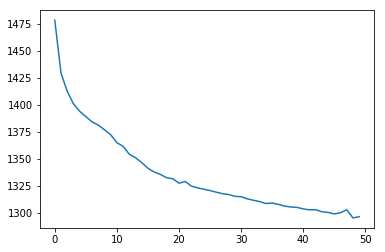

In [7]:
test = pickle.load(open(f'{PATH}/training/test_losses.pkl', 'rb'))
plt.plot(test)

In [23]:
def load_last_model():
    models = glob.glob(f'{PATH}/training/models/*.pth')
    model_ids = [(int(f.split('_')[1]), f) for f in models]
    start_epoch, last_cp = max(model_ids, key=lambda item:item[0])
    print('Last checkpoint: ', last_cp)
    model = torch.load(last_cp, map_location=DEVICE)
    return model

Last checkpoint:  /scratch/users/johmathe/output/training/models/epoch_49_train_loss_1287.1594_test_loss_1296.5697.pth


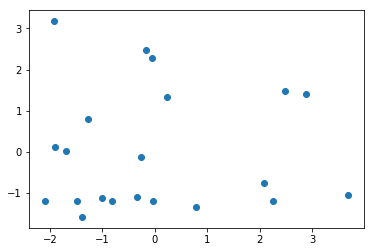

interactive(children=(FloatSlider(value=0.0, description='c1', max=6.0, min=-6.0), FloatSlider(value=0.0, desc…

In [41]:
from sklearn.decomposition import PCA
N_COMPONENTS = 2

model = load_last_model()

with open(f'{PATH}/test.pkl', 'rb') as test_pkl:
    test = pickle.load(test_pkl)

test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True)

# Euclidean PCA on the Gaussian means learnt by the model
mus = []
for i, data in enumerate(test_loader):
    if i > 20:
        break
    data = data[0].to(DEVICE)
    recon_batch, mu, logvar = model(data)
    mus.append(np.array(mu.cpu().detach()))

mus = np.array(mus).squeeze()

pca = PCA(n_components=N_COMPONENTS)
pca.fit(mus)
projected_mus = pca.transform(mus)

plt.scatter(projected_mus[:, 0], projected_mus[:, 1])

# Slide along the first principal component
first_component = pca.components_[0]
second_component = pca.components_[1]

@interact(c1=FloatSlider(min=-6,max=6,step=0.1,value=0), c2=FloatSlider(min=-6,max=6,step=0.1,value=0))
def display_image(c1, c2):
    z = c1 * first_component + c2 * second_component
    z = torch.Tensor(z).cuda()
    recon = model.decode(z)
    recon = recon.squeeze()
    plt.imshow(recon.detach().cpu(), cmap='afmhot')

    